In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import networkx as nx
from scipy.spatial import distance
from tqdm import tqdm

# Экспоненциальное распределение
def generate_exponential_samples(n, lambda_param):
    samples = np.random.exponential(1/lambda_param, n)
    return samples

# Гамма распределение
def generate_gamma_samples(n, lambda_param):
    alpha = 1 / 2
    samples = np.random.gamma(alpha, 1 / lambda_param, n)
    return samples

#Генерация Normal(0,σ);
def generate_normal_samles(size, loc=0, scale=1):
    return np.random.normal(loc, scale, size)

#Генерация Student-t(ν)
def generate_standard_t_samles(size, df=3):
    return np.random.standard_t(df, size)

# Построение knn-графа
def generate_knn_digraph(sample, k):
    G = nx.DiGraph()
    sample = np.asarray(sample)
    if sample.ndim == 1:
        sample = sample.reshape(-1, 1)

    n_samples = len(sample)
    if k >= n_samples - 1:
        G.add_nodes_from(range(n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                if i != j:
                    G.add_edge(i, j)
        return G
    G.add_nodes_from(range(n_samples))
    dist_matrix = distance.squareform(distance.pdist(sample))
    for i in range(n_samples):
      neighbors = np.argsort(dist_matrix[i])[1:k+1]
      for neighbor in neighbors:
        G.add_edge(i, neighbor)
    return G

# Построение дистанционного графа
def generate_distance_graph(sample, d):
    G = nx.Graph()

    for i in range(len(sample)):
        G.add_node(i, pos=(sample[i], 0))

    for i in range(len(sample)):
        for j in range(i + 1, len(sample)):
            if abs(sample[i] - sample[j]) <= d:
                G.add_edge(i, j)
    '''
    pos = nx.get_node_attributes(G, 'pos')
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
    plt.title(f'Distance Graph with d = {d}')
    plt.xlabel('Sample Values')
    plt.yticks([])
    plt.show()
    '''
    return G

# макс степень вершины
def max_node_degree(graph):
    if not graph:
        return 0

    degrees = dict(graph.degree())
    max_degree = max(degrees.values())
    return max_degree

# макс. независимое множество UML-диаграмма реализованных классо UML-диаграмма реализованных классо
def max_independent_set_size(graph):
    if not graph:
        return 0
    independent_set = nx.algorithms.approximation.maximum_independent_set(graph)
    return len(independent_set)

#δ(G) - минимальная степень
def min_node_degree(graph):
    if not graph:
        return 0
    degrees = dict(graph.in_degree())
    return min(degrees.values())

#χ(G) - Хроматическое число
def chromatic_number(graph):
    if not graph:
        return 0
    coloring = nx.algorithms.coloring.greedy_color(graph, strategy='largest_first', interchange=True)
    return max(coloring.values()) + 1

**Исследование того, как ведет себя числовая характеристика T в зависимости
от параметров распределений θ и υ  и параметр процедуры построения графа, при фиксированном размере выборки.**

Эксперементы с графом knn и нормальным распределением.

Processing k_neighbors: 100%|██████████| 6/6 [05:58<00:00, 59.76s/it]


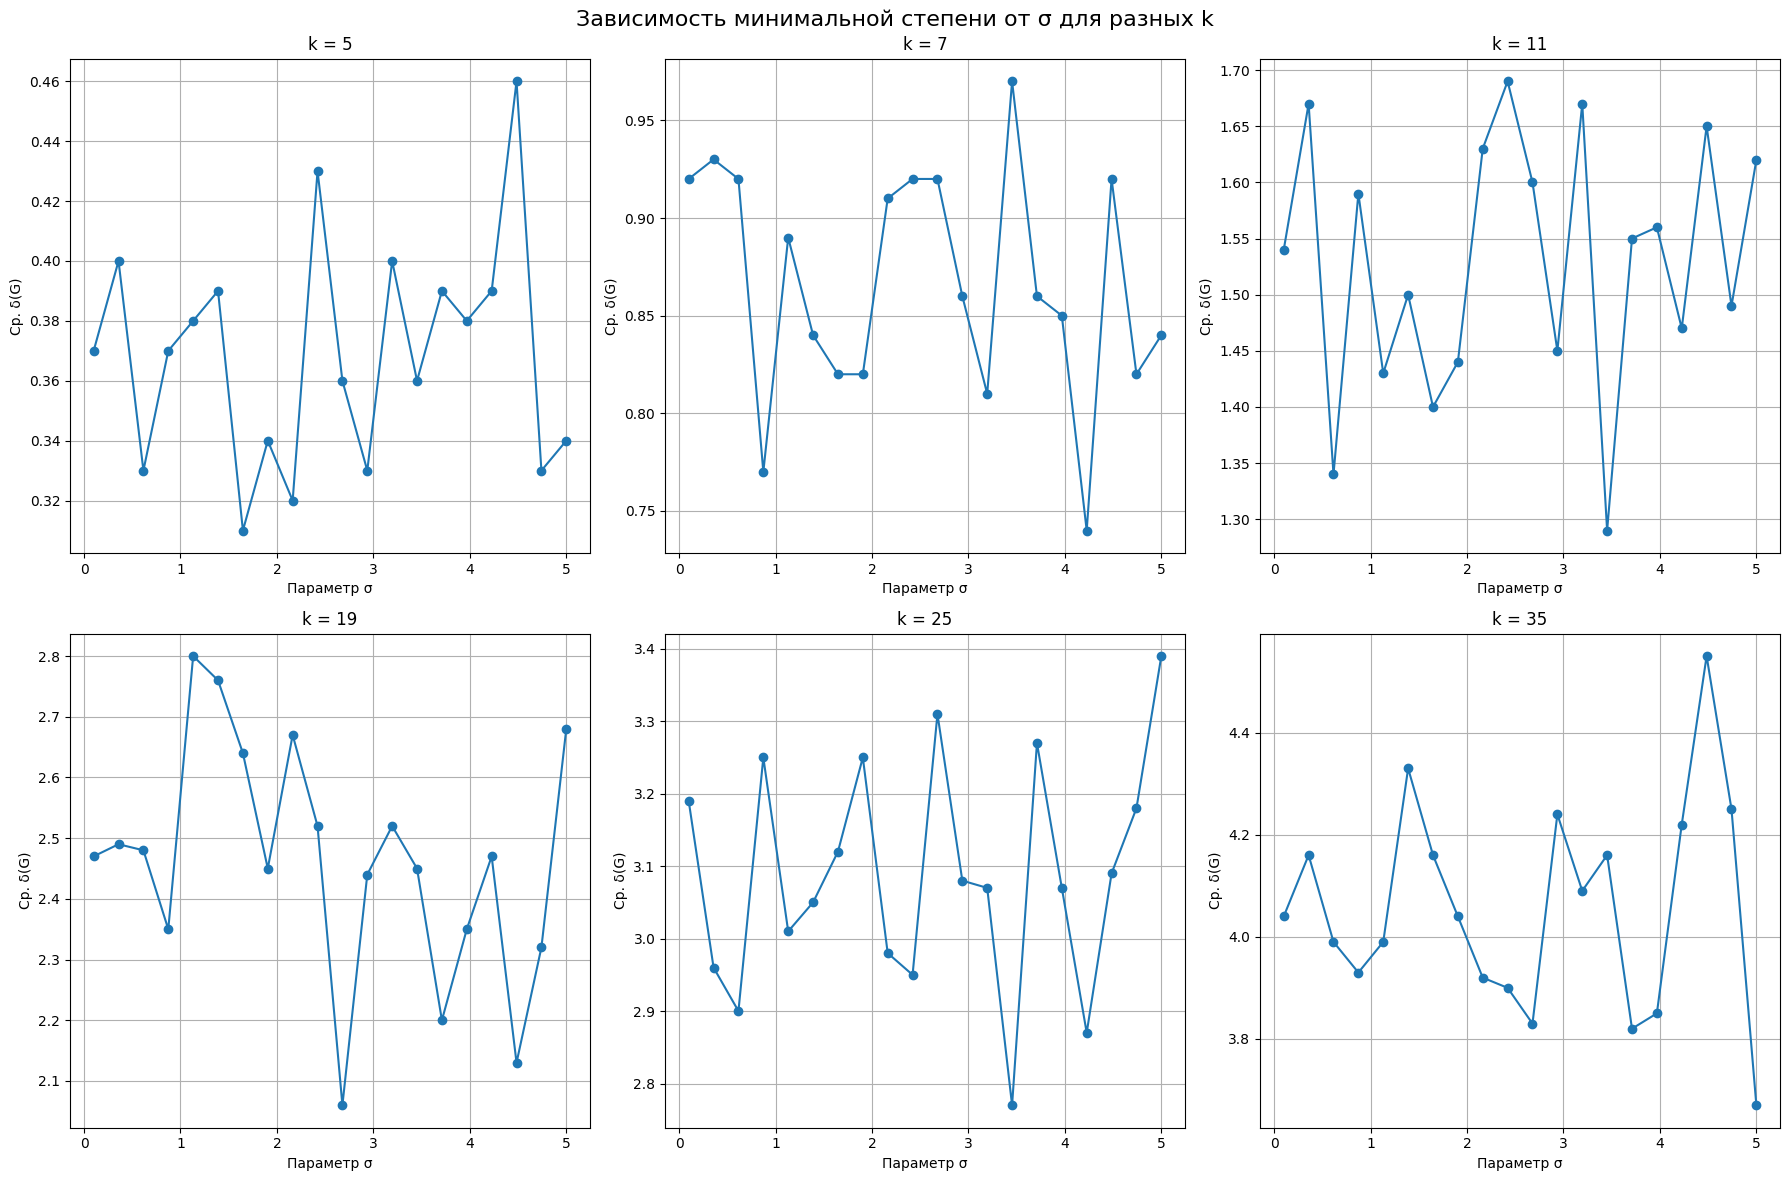

In [4]:
param_grid = {
    'k_neighbors': [5, 7, 11, 19, 25, 35],
    'scale': np.linspace(0.1, 5.0, 20)
}
n = 500
n_trials = 100
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
fig.suptitle('Зависимость минимальной степени от σ для разных k', fontsize=16)
for i, k in enumerate(tqdm(param_grid['k_neighbors'], desc='Processing k_neighbors')):
    min_degrees_means = []
    for scale in param_grid['scale']:
        min_degrees = []
        for _ in range(n_trials):
            samples = generate_normal_samles(n,scale=scale)
            G = generate_knn_digraph(samples, k)
            min_degree = min_node_degree(G)
            min_degrees.append(min_degree)
        min_degrees_means.append(np.mean(min_degrees))
    ax = axes[i//3, i%3]
    ax.plot(param_grid['scale'], min_degrees_means, marker='o')
    ax.set_title(f'k = {k}')
    ax.set_xlabel('Параметр σ')
    ax.set_ylabel('Ср. δ(G)')
    ax.grid(True)
plt.tight_layout()
plt.show()






Эксперементы с графом knn и Student-t(ν).

Processing k_neighbors: 100%|██████████| 6/6 [06:23<00:00, 63.87s/it]


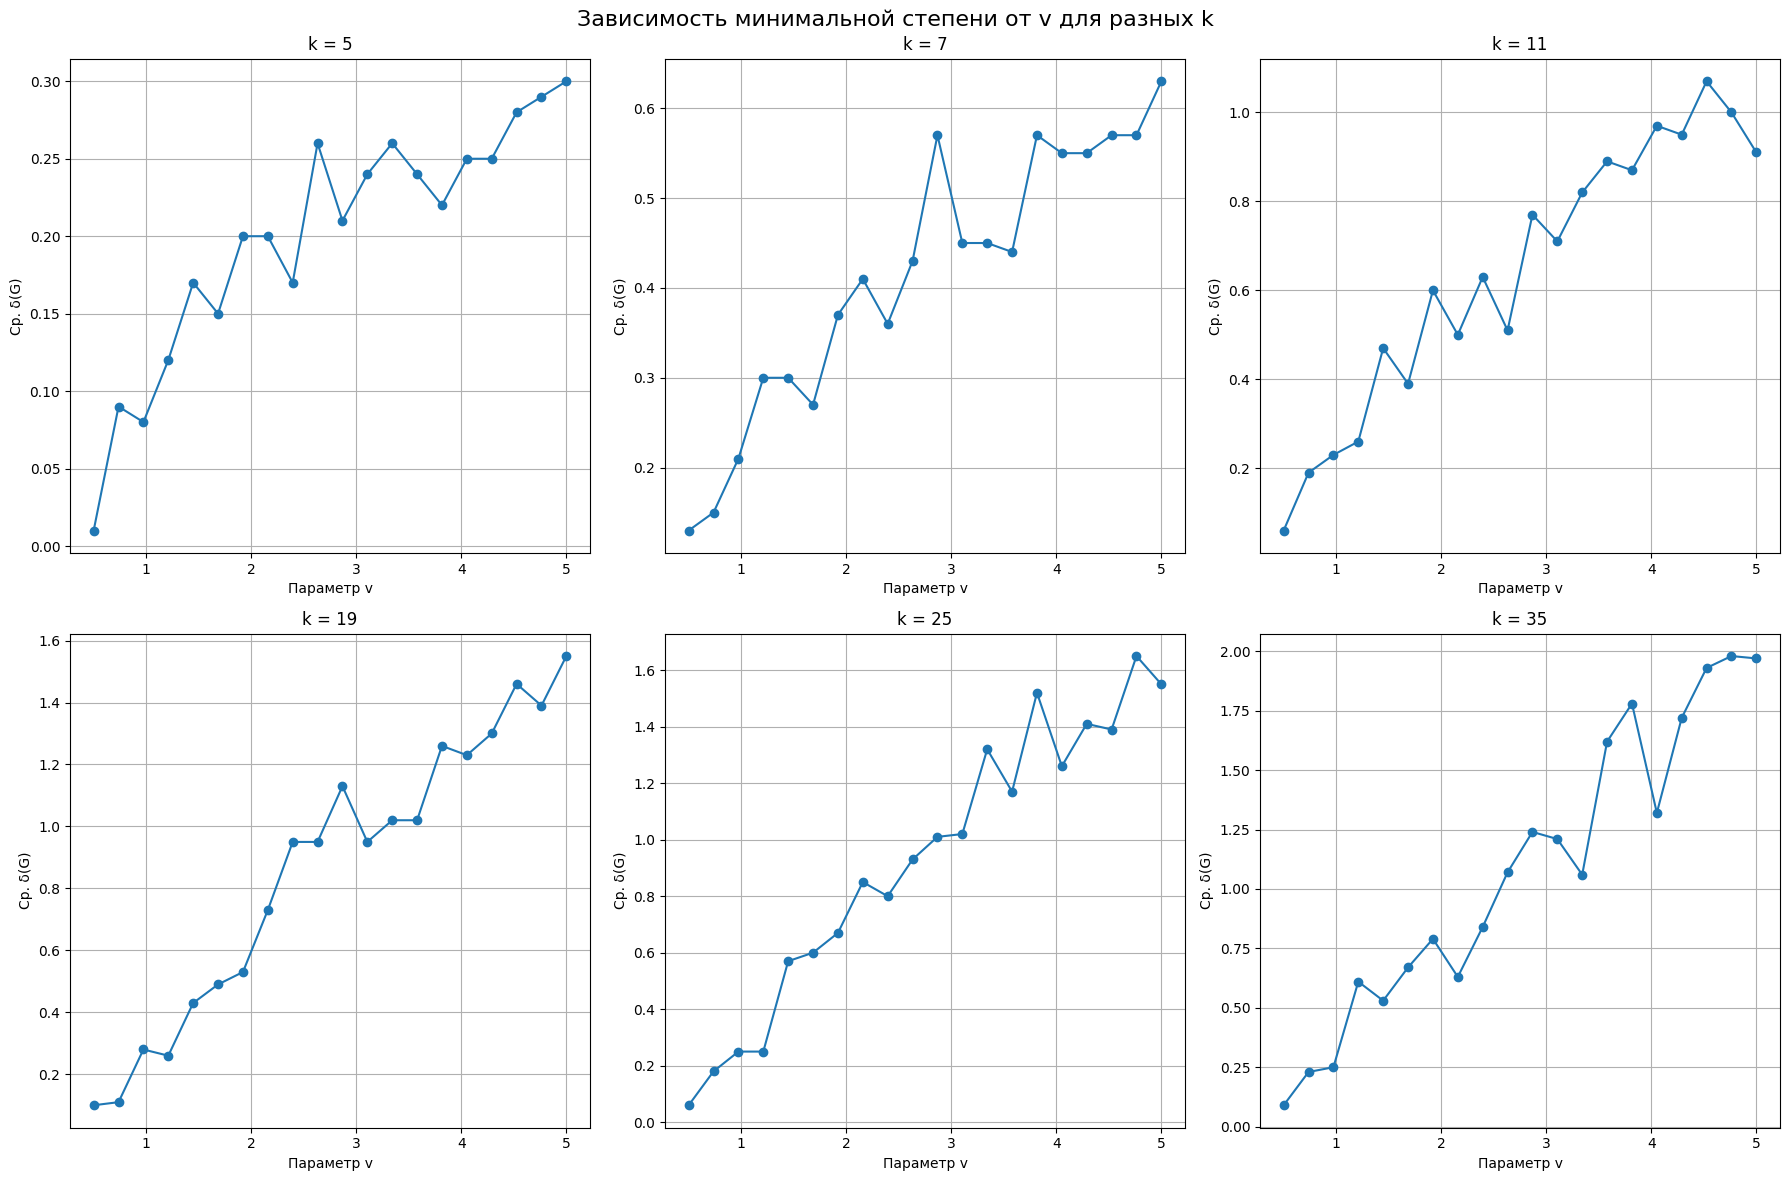

In [5]:
param_grid = {
    'k_neighbors': [5, 7, 11, 19, 25, 35],
    'df': np.linspace(0.5, 5.0, 20)
}
n = 500
n_trials = 100
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
fig.suptitle('Зависимость минимальной степени от v для разных k', fontsize=16)
for i, k in enumerate(tqdm(param_grid['k_neighbors'], desc='Processing k_neighbors')):
    min_degrees_means = []
    for v in param_grid['df']:
        min_degrees = []
        for _ in range(n_trials):
            samples = generate_standard_t_samles(n,df=v)
            G = generate_knn_digraph(samples, k)
            min_degree = min_node_degree(G)
            min_degrees.append(min_degree)
        min_degrees_means.append(np.mean(min_degrees))
    ax = axes[i//3, i%3]
    ax.plot(param_grid['df'], min_degrees_means, marker='o')
    ax.set_title(f'k = {k}')
    ax.set_xlabel('Параметр v')
    ax.set_ylabel('Ср. δ(G)')
    ax.grid(True)
plt.tight_layout()
plt.show()

Мы получили интересный результат. График для нормального распределения выглядит хоотичнее, чем график для Student-t(ν), в графике Student-t(ν) прослеживается рост матожидания минимальной входящей степени вершины, с ростом параметра v. И еще одно интересное наблюдение: для интересующих нас параметром распределений $v_0$ и $\sigma_0$ график распределения Student-t(ν) ниже графика нормального распределения.

Эксперементы с графом knn и экспоненциальным распределением.

Processing k_neighbors: 100%|██████████| 6/6 [05:43<00:00, 57.17s/it]


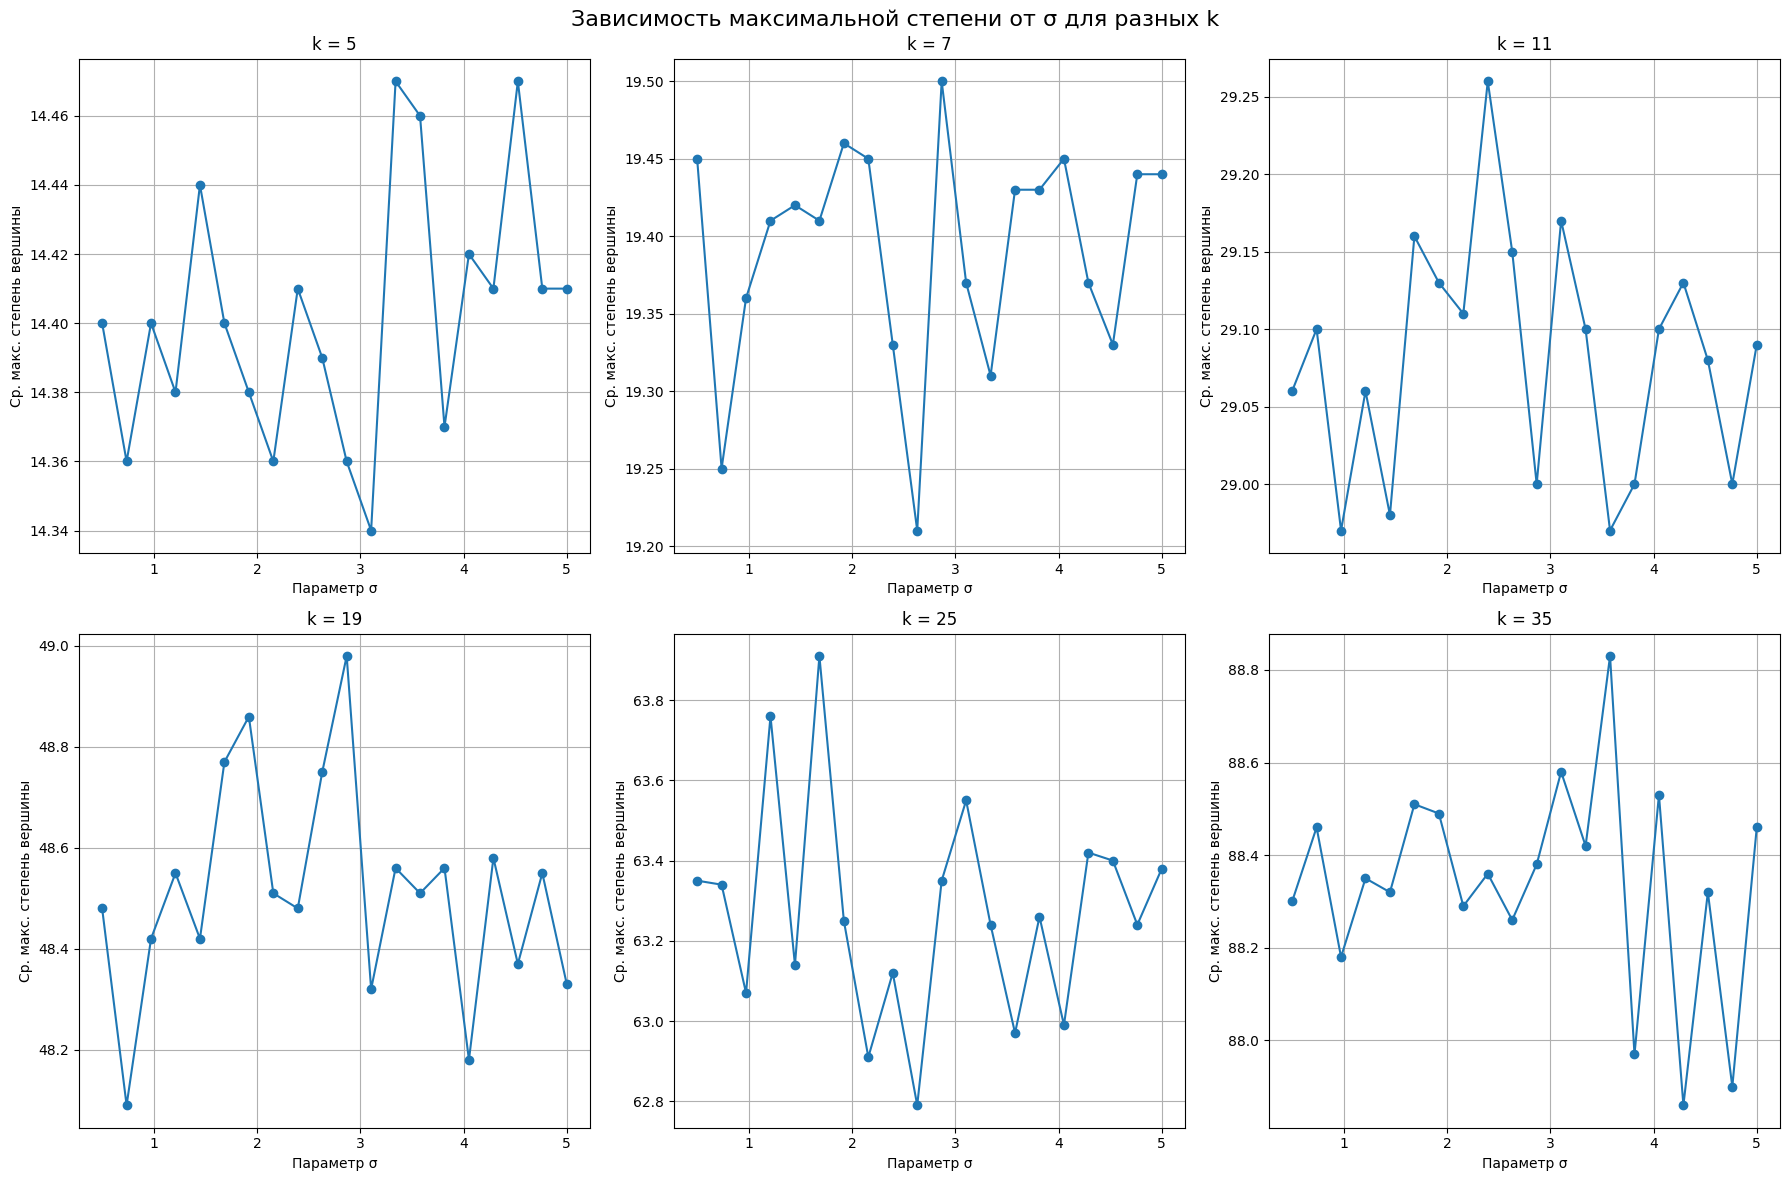

In [6]:
param_grid = {
    'k_neighbors': [5, 7, 11, 19, 25, 35],
    'lambda_p': np.linspace(0.5, 5.0, 20)
}
n = 500
n_trials = 100
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
fig.suptitle('Зависимость максимальной степени от σ для разных k', fontsize=16)
for i, k in enumerate(tqdm(param_grid['k_neighbors'], desc='Processing k_neighbors')):
    max_degrees_means = []
    for lambda_ in param_grid['lambda_p']:
        max_degrees = []
        for _ in range(n_trials):
            samples = generate_exponential_samples(n, lambda_param= lambda_)
            G = generate_knn_digraph(samples, k)
            max_degree = max_node_degree(G)
            max_degrees.append(max_degree)
        max_degrees_means.append(np.mean(max_degrees))
    ax = axes[i//3, i%3]
    ax.plot(param_grid['lambda_p'], max_degrees_means, marker='o')
    ax.set_title(f'k = {k}')
    ax.set_xlabel('Параметр σ')
    ax.set_ylabel('Ср. макс. степень вершины')
    ax.grid(True)
plt.tight_layout()
plt.show()

Эксперементы с графом knn и Гамма распределением.

Processing k_neighbors: 100%|██████████| 6/6 [05:42<00:00, 57.05s/it]


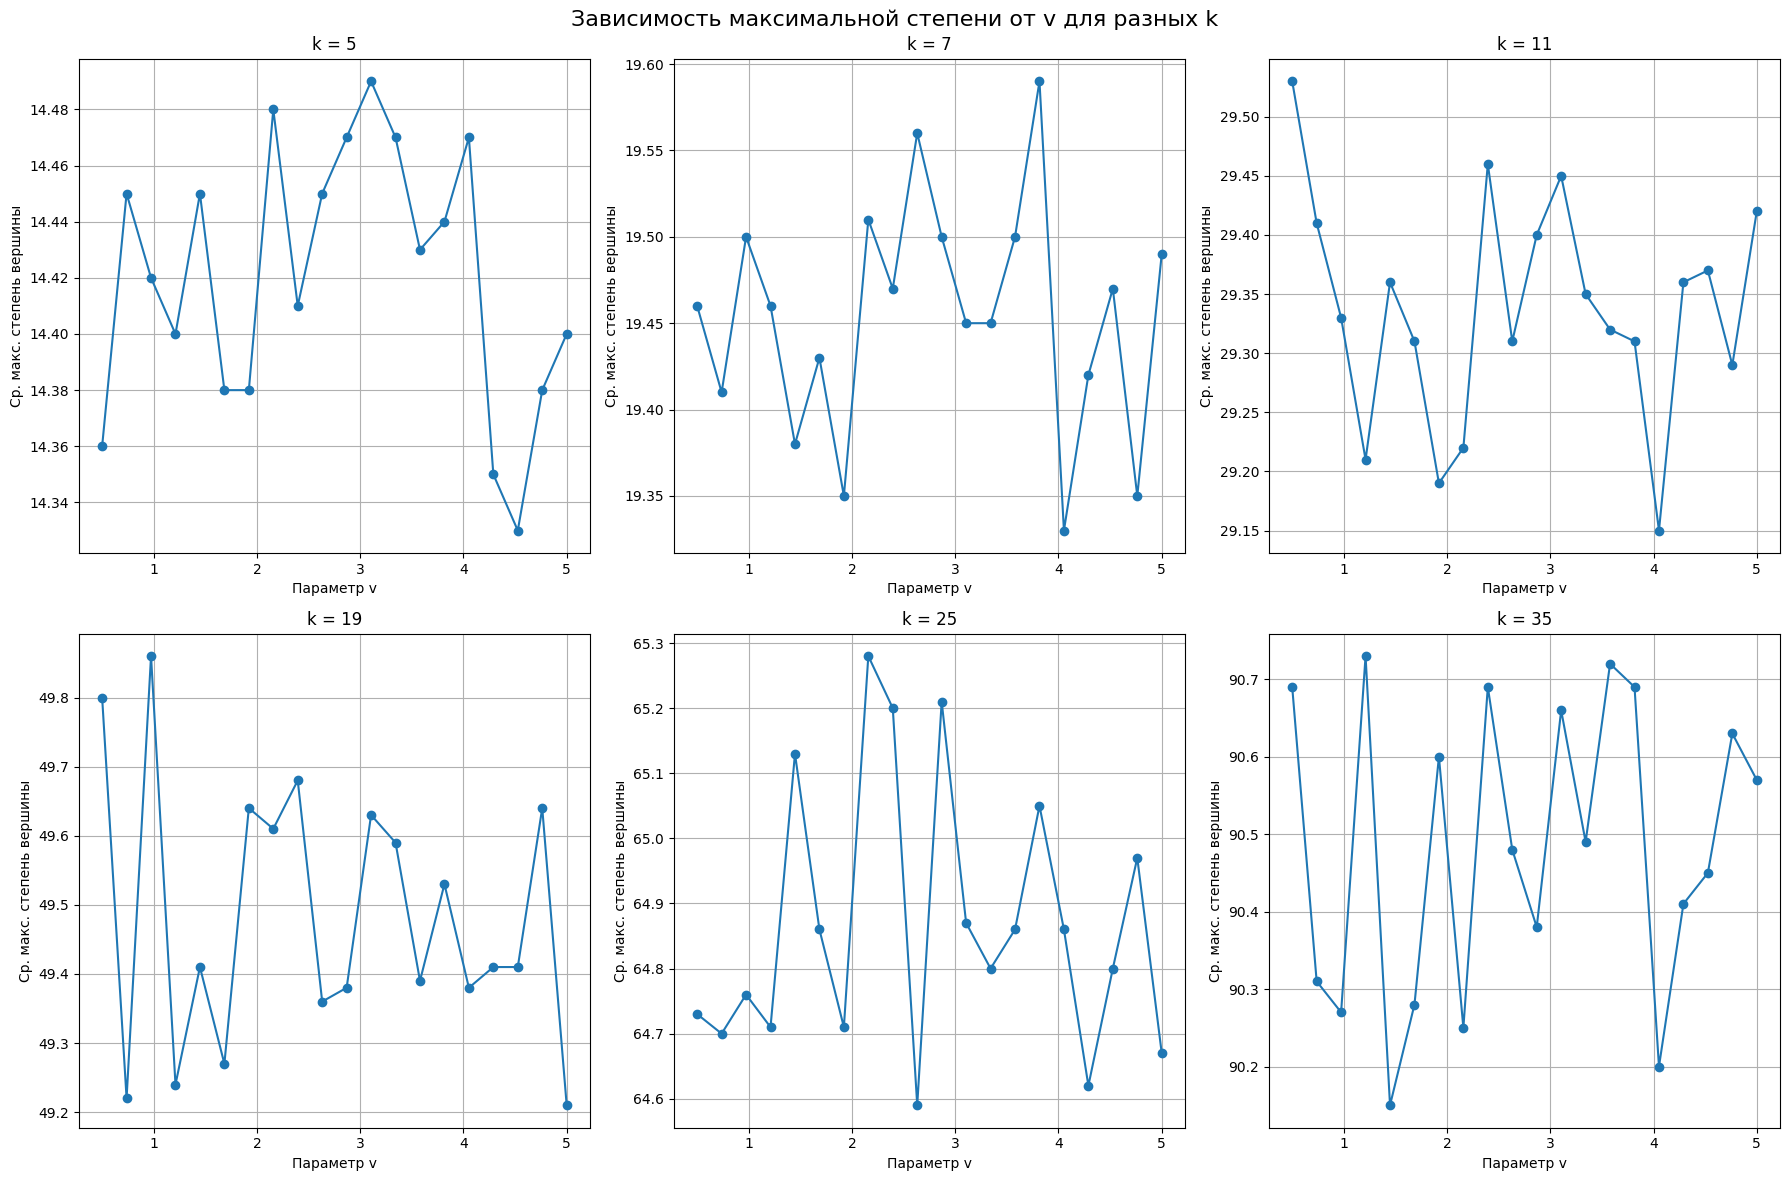

In [7]:
param_grid = {
    'k_neighbors': [5, 7, 11, 19, 25, 35],
    'lambda_p': np.linspace(0.5, 5.0, 20)
}
n = 500
n_trials = 100
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
fig.suptitle('Зависимость максимальной степени от v для разных k', fontsize=16)
for i, k in enumerate(tqdm(param_grid['k_neighbors'], desc='Processing k_neighbors')):
    max_degrees_means = []
    for lambda_ in param_grid['lambda_p']:
        max_degrees = []
        for _ in range(n_trials):
            samples = generate_gamma_samples(n, lambda_param= lambda_)
            G = generate_knn_digraph(samples, k)
            max_degree = max_node_degree(G)
            max_degrees.append(max_degree)
        max_degrees_means.append(np.mean(max_degrees))
    ax = axes[i//3, i%3]
    ax.plot(param_grid['lambda_p'], max_degrees_means, marker='o')
    ax.set_title(f'k = {k}')
    ax.set_xlabel('Параметр v')
    ax.set_ylabel('Ср. макс. степень вершины')
    ax.grid(True)
plt.tight_layout()
plt.show()

Зависимости экспоненциального и гамма распределений от параметров q и v выглядят очень хаотично.

Эксперементы с графом dist и нормальным распределением.

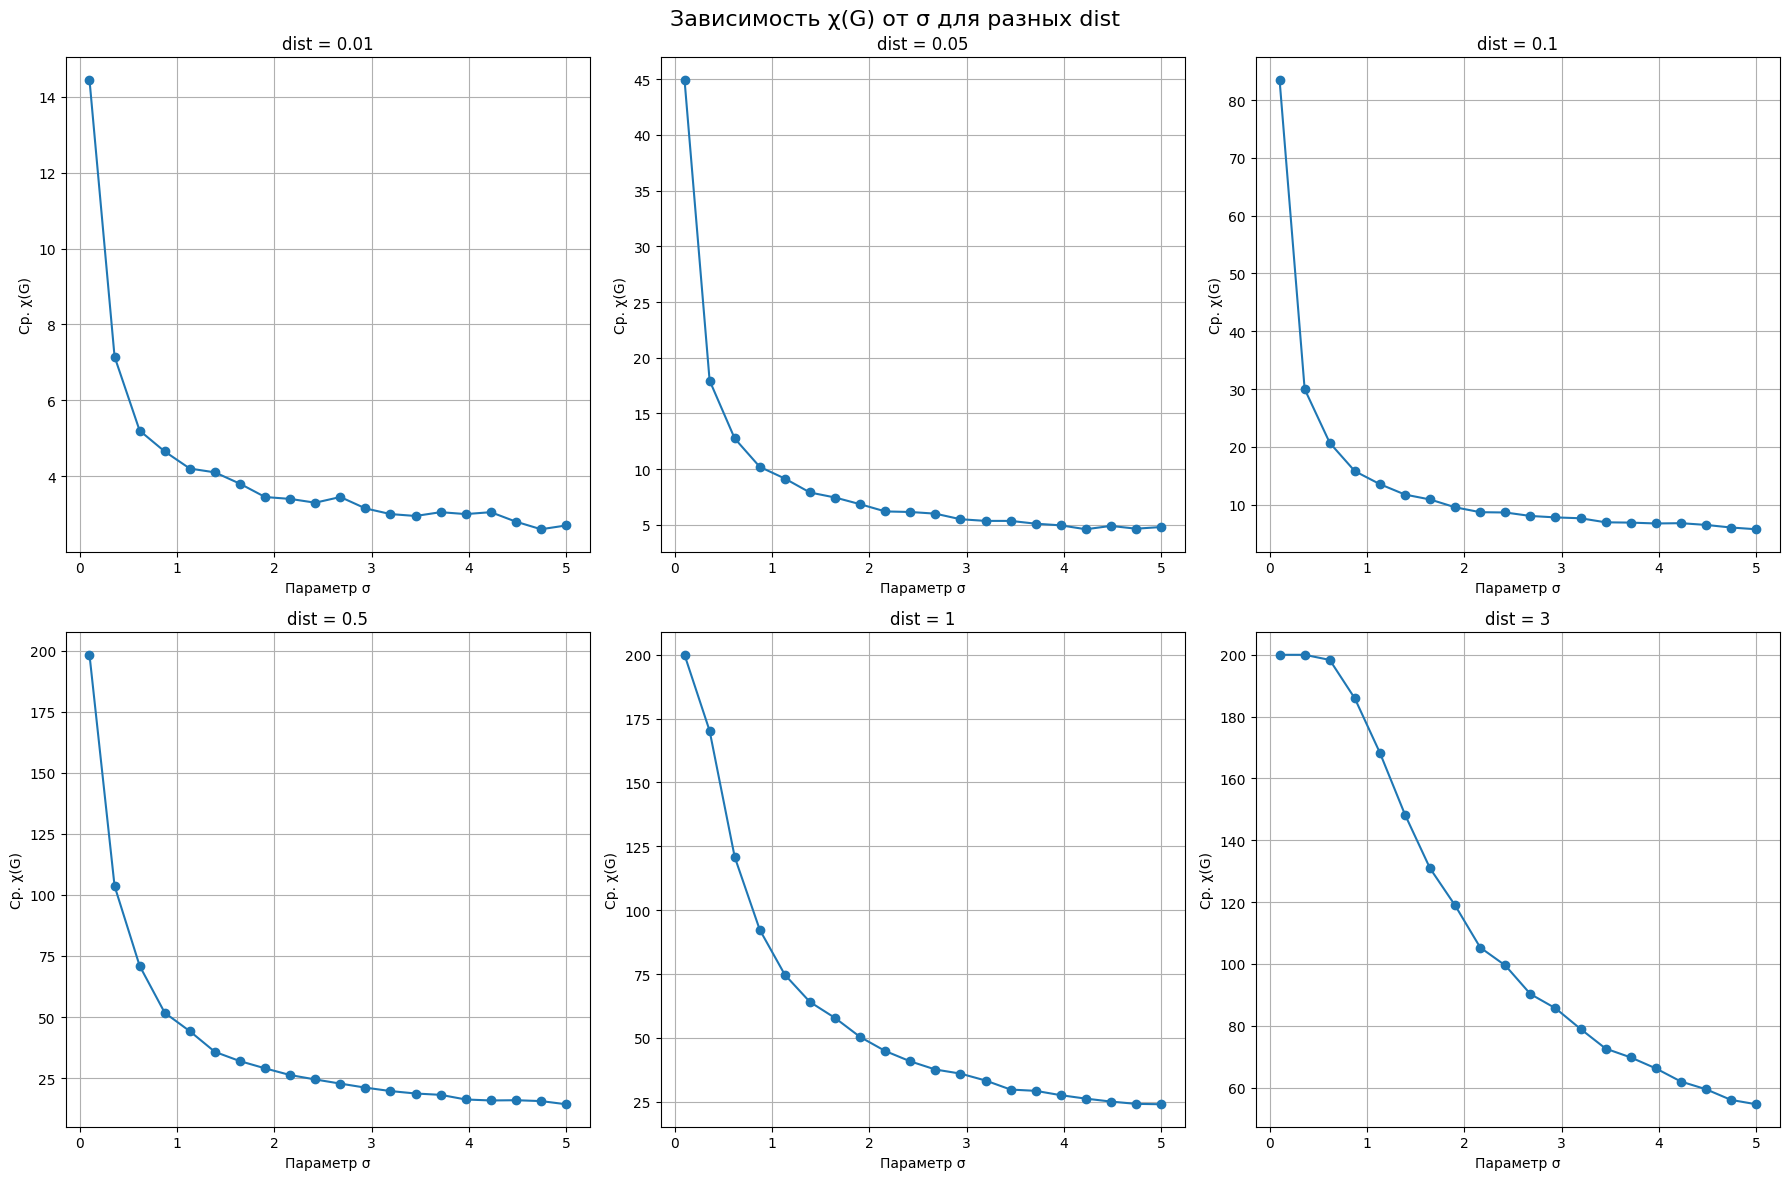

In [8]:
param_grid = {
    'dist': [0.01, 0.05, 0.1, 0.5, 1, 3],
    'scale': np.linspace(0.1, 5.0, 20)
}
n = 200
n_trials = 20
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
fig.suptitle('Зависимость χ(G) от σ для разных dist', fontsize=16)
for i, d in enumerate(param_grid['dist']):
    chromatic_means = []
    for scale in param_grid['scale']:
        chromatics = []
        for _ in range(n_trials):
            samples = generate_normal_samles(n,scale=scale)
            G = generate_distance_graph(samples, d = d)
            chromatic = chromatic_number(G)
            chromatics.append(chromatic)
        chromatic_means.append(np.mean(chromatics))
    ax = axes[i//3, i%3]
    ax.plot(param_grid['scale'], chromatic_means, marker='o')
    ax.set_title(f'dist = {d}')
    ax.set_xlabel('Параметр σ')
    ax.set_ylabel('Ср. χ(G)')
    ax.grid(True)
plt.tight_layout()
plt.show()


Эксперементы с графом dist и Student-t(ν).

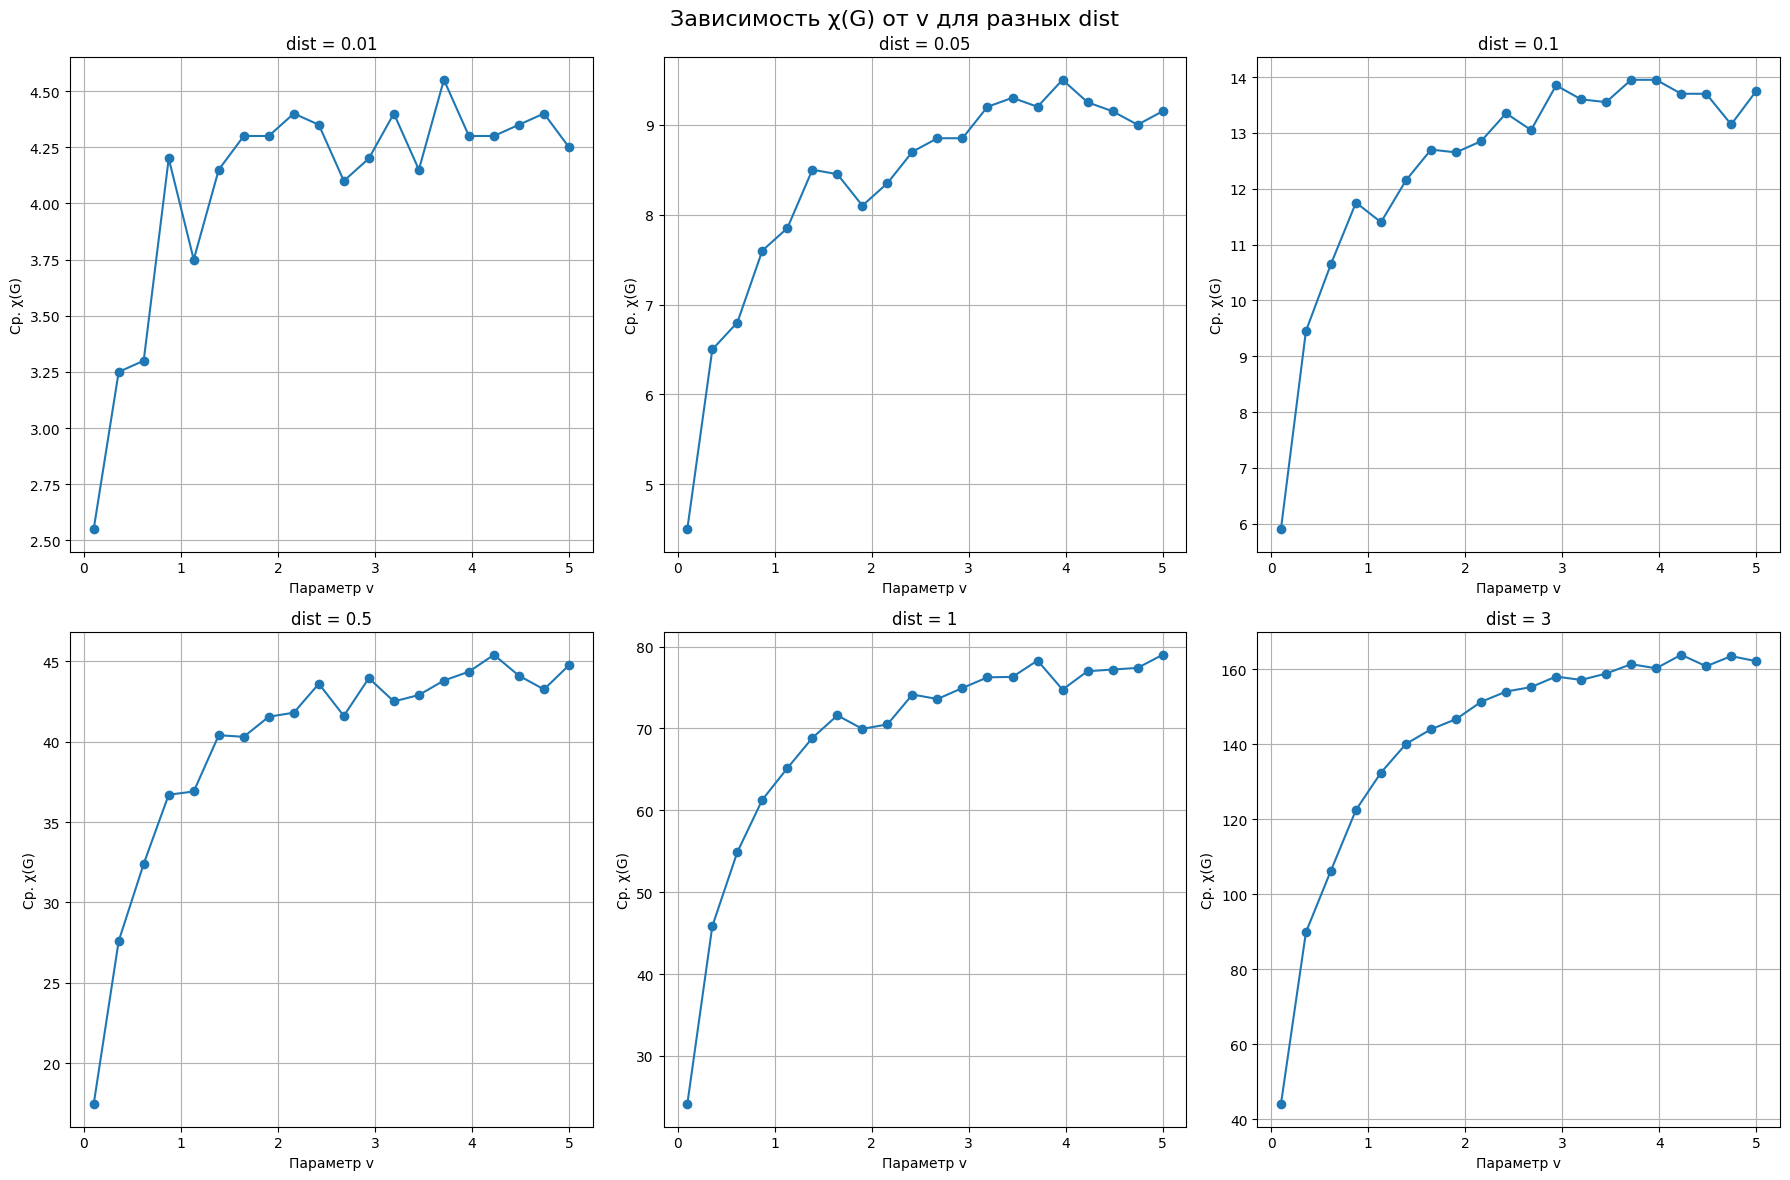

In [9]:
param_grid = {
    'dist': [0.01, 0.05, 0.1, 0.5, 1, 3],
    'v': np.linspace(0.1, 5.0, 20)
}
n = 200
n_trials = 20
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
fig.suptitle('Зависимость χ(G) от v для разных dist', fontsize=16)
for i, d in enumerate(param_grid['dist']):
    chromatic_means = []
    for v in param_grid['v']:
        chromatics = []
        for _ in range(n_trials):
            samples = generate_standard_t_samles(n,df=v)
            G = generate_distance_graph(samples, d = d)
            chromatic = chromatic_number(G)
            chromatics.append(chromatic)
        chromatic_means.append(np.mean(chromatics))
    ax = axes[i//3, i%3]
    ax.plot(param_grid['v'], chromatic_means, marker='o')
    ax.set_title(f'dist = {d}')
    ax.set_xlabel('Параметр v')
    ax.set_ylabel('Ср. χ(G)')
    ax.grid(True)
plt.tight_layout()
plt.show()


Характеристика χ(G) на дистанционном графе показывает разные результаты для разных выборок. Для нормального распределения с ростом параметра σ хроматическое число убывает, а для распределения Student-t(ν) с ростом параметра v хроматическое число наооборот растет. Эта комбинация (χ(G) на дистанционном графе) может подойти для определения истинности гипотез.

Эксперементы с графом dist и экспоненциальным распределением.

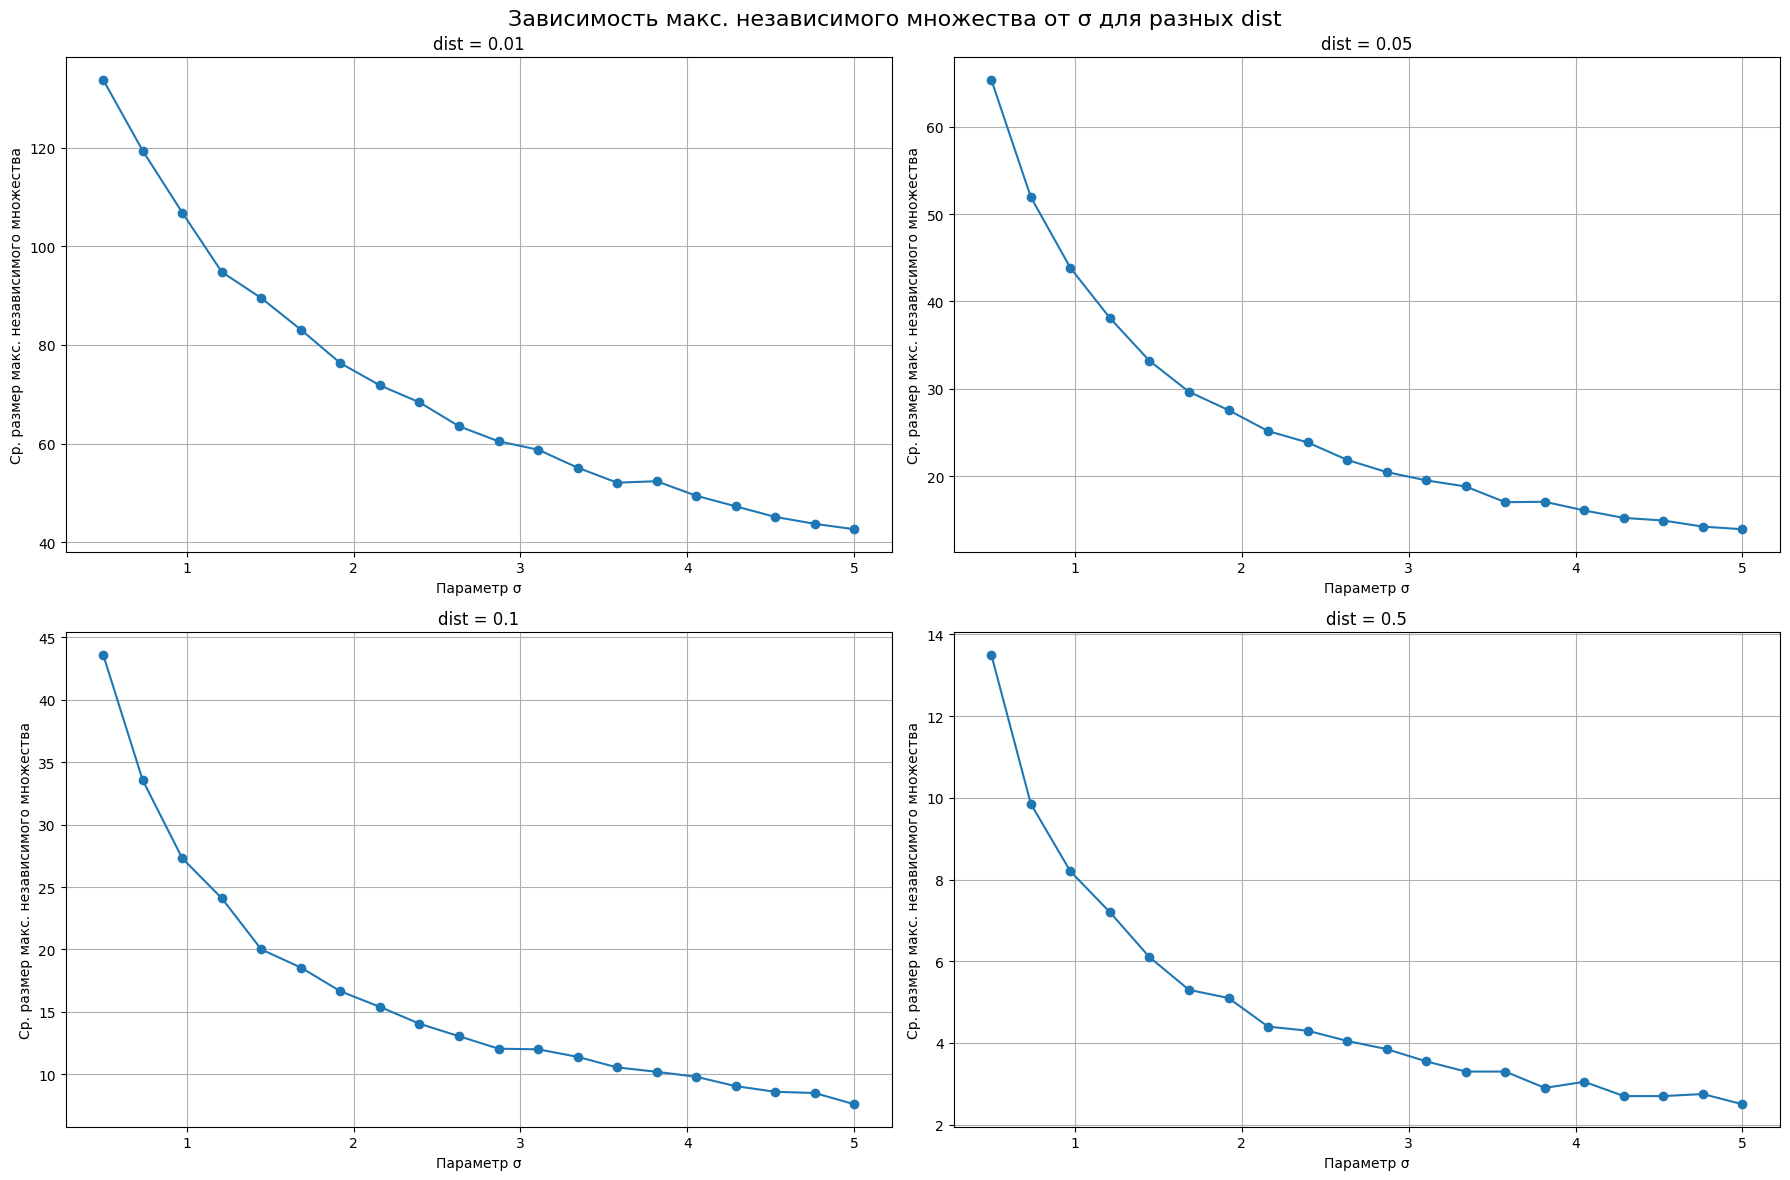

In [13]:
param_grid = {
    'dist': [0.01, 0.05, 0.1, 0.5],
    'lambda_p': np.linspace(0.5, 5.0, 20)
}
n = 200
n_trials = 20
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
fig.suptitle('Зависимость макс. независимого множества от σ для разных dist', fontsize=16)
for i, d in enumerate(param_grid['dist']):
    independent_set_means = []
    for lambda_ in param_grid['lambda_p']:
        independent_set = []
        for _ in range(n_trials):
            samples = generate_exponential_samples(n, lambda_)
            G = generate_distance_graph(samples, d = d)
            independent = max_independent_set_size(G)
            independent_set.append(independent)
        independent_set_means.append(np.mean(independent_set))
    ax = axes[i//2, i%2]
    ax.plot(param_grid['lambda_p'], independent_set_means, marker='o')
    ax.set_title(f'dist = {d}')
    ax.set_xlabel('Параметр σ')
    ax.set_ylabel('Ср. размер макс. независимого множества')
    ax.grid(True)
plt.tight_layout()
plt.show()

Эксперементы с графом dist и Гамма распределением.

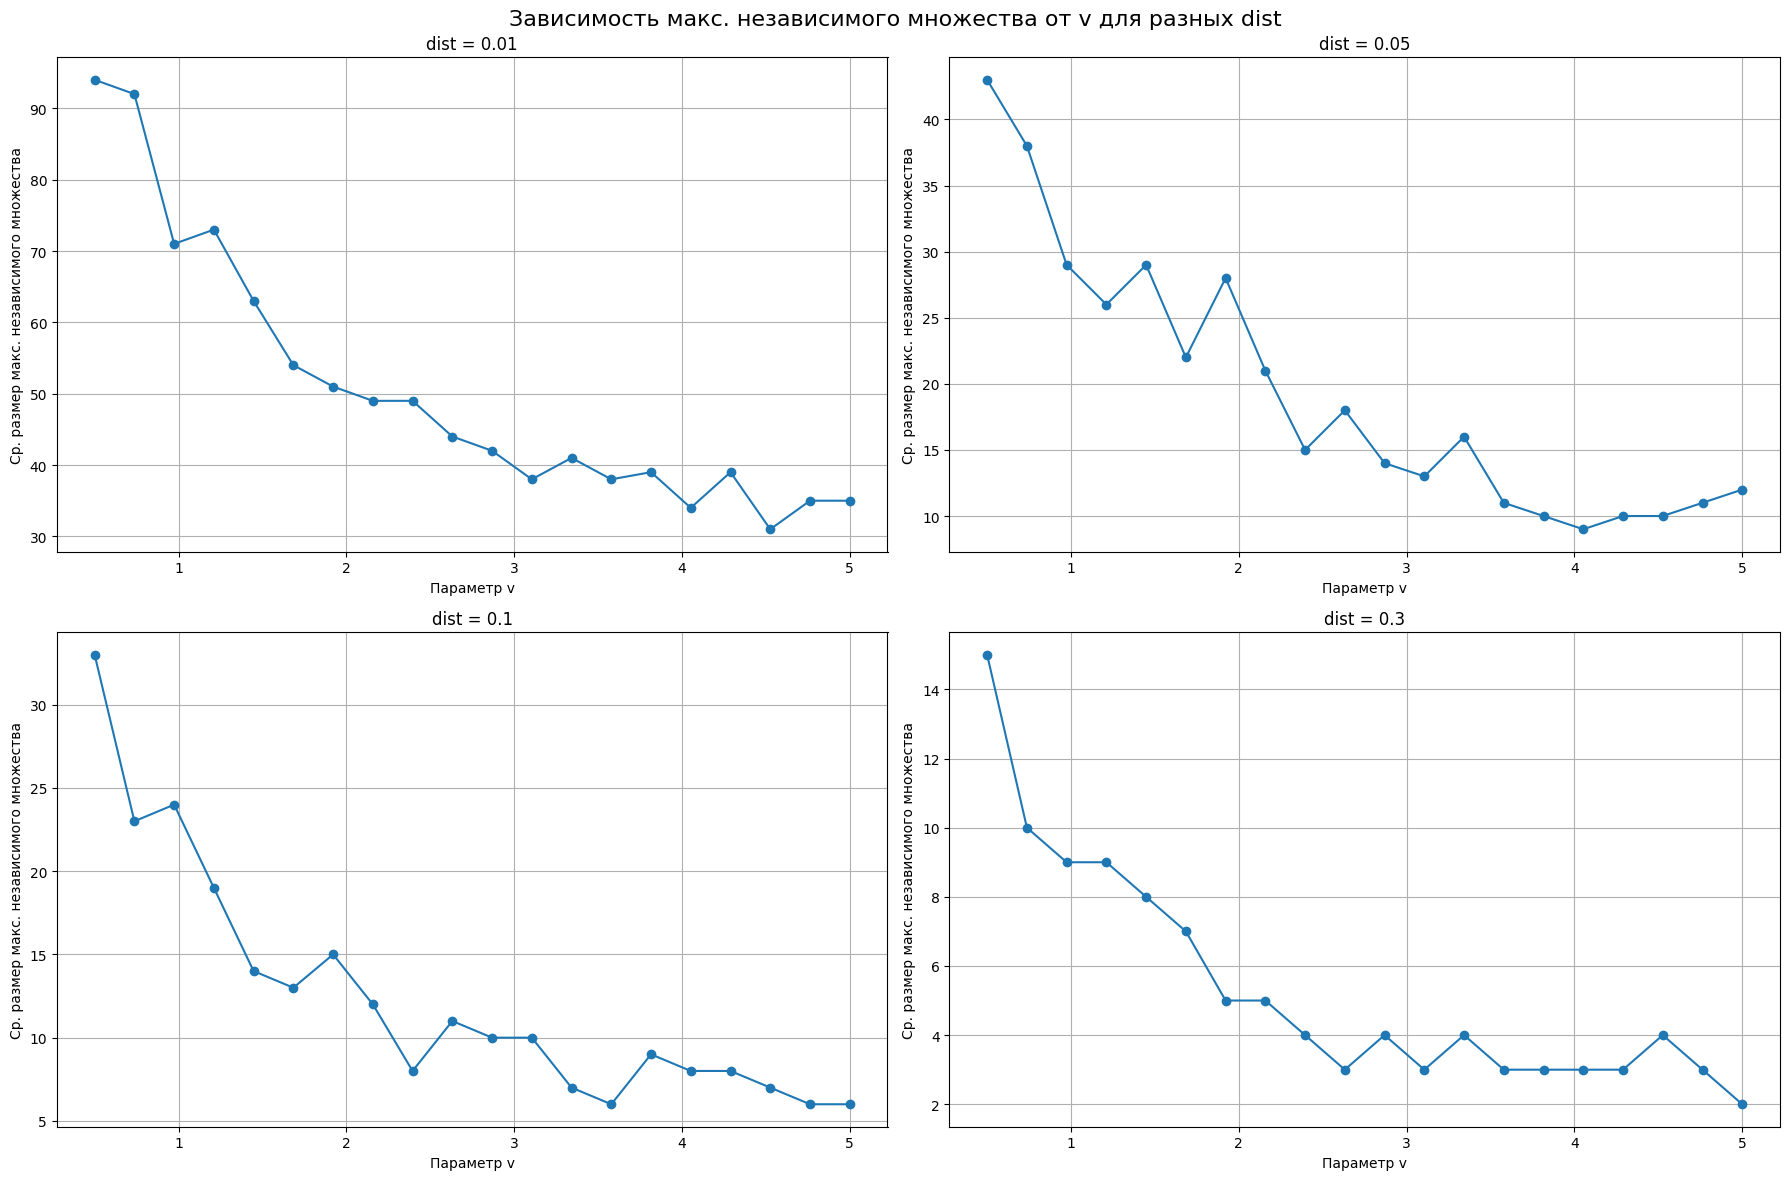

In [16]:
param_grid = {
    'dist': [0.01, 0.05, 0.1, 0.3],
    'lambda_p': np.linspace(0.5, 5.0, 20)
}
n = 200
n_trials = 20
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
fig.suptitle('Зависимость макс. независимого множества от v для разных dist', fontsize=16)
for i, d in enumerate(param_grid['dist']):
    independent_set_means = []
    for lambda_ in param_grid['lambda_p']:
        independent_set = []
        for _ in range(n_trials):
            samples = generate_gamma_samples(n, lambda_)
            G = generate_distance_graph(samples, d = d)
            independent = max_independent_set_size(G)
            independent_set.append(independent)
        independent_set_means.append(np.mean(independent))
    ax = axes[i//2, i%2]
    ax.plot(param_grid['lambda_p'], independent_set_means, marker='o')
    ax.set_title(f'dist = {d}')
    ax.set_xlabel('Параметр v')
    ax.set_ylabel('Ср. размер макс. независимого множества')
    ax.grid(True)
plt.tight_layout()
plt.show()

Размер максимального независимого множвества убывает с увеличением параметра q и v. Однако для гамма распределения зависимость несколько более хаотичная.

**Исследование того, как ведет себя числовая характеристика T в зависимости
от параметров процедуры построения графа и размера выборки при
фиксированных значениях $θ = θ_0$ и $υ = υ_0$**

Эксперементы с графом knn.

Processing k_neighbors: 100%|██████████| 6/6 [00:09<00:00,  1.52s/it]


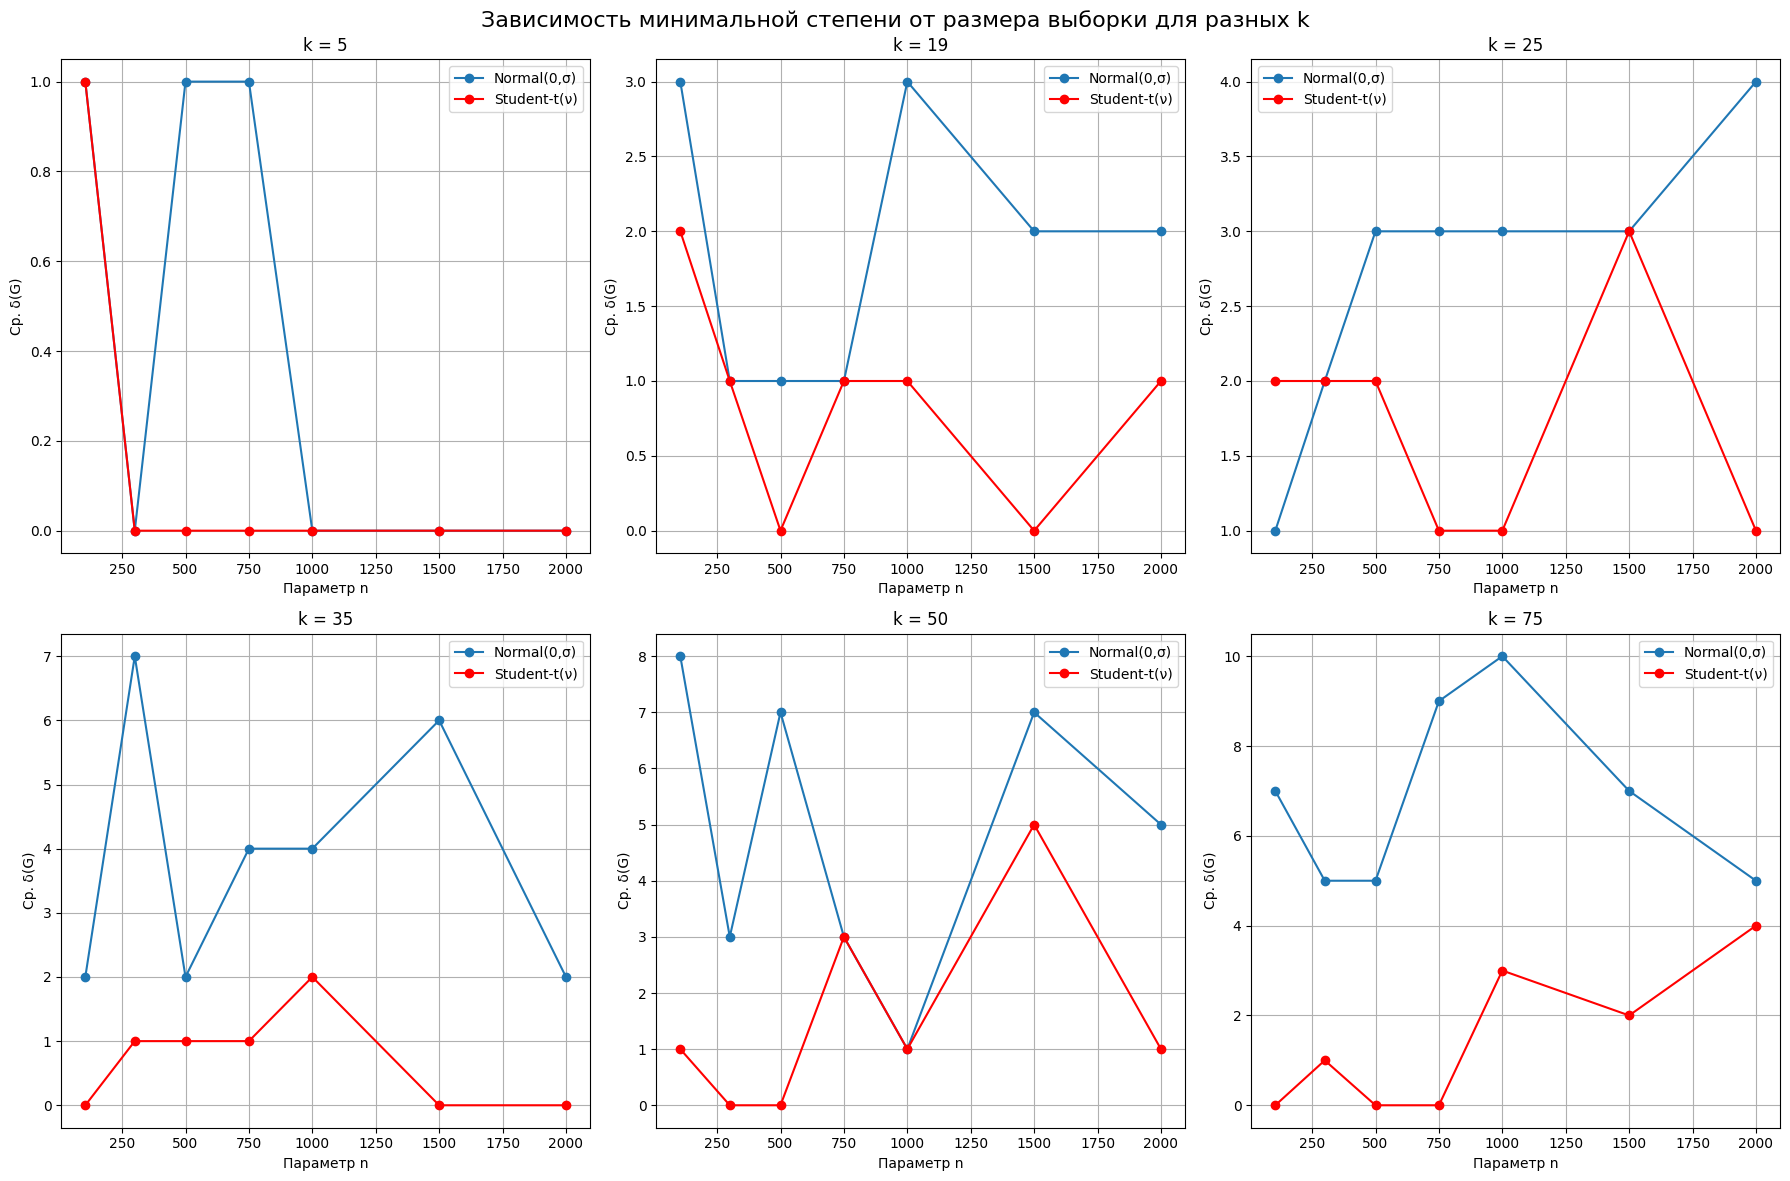

In [17]:
param_grid = {
    'k_neighbors': [5, 19, 25, 35, 50, 75],
    'n': [105, 300, 500, 750, 1000, 1500, 2000]
}
n_trials = 1
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
fig.suptitle('Зависимость минимальной степени от размера выборки для разных k', fontsize=16)
for i, k in enumerate(tqdm(param_grid['k_neighbors'], desc='Processing k_neighbors')):
    min_degrees_means = []
    for n in param_grid['n']:
        min_degrees = []
        for _ in range(n_trials):
            samples = generate_normal_samles(n)
            G = generate_knn_digraph(samples, k)
            min_degree = min_node_degree(G)
            min_degrees.append(min_degree)
        min_degrees_means.append(np.mean(min_degrees))
    ax = axes[i//3, i%3]
    ax.plot(param_grid['n'], min_degrees_means, marker='o', label='Normal(0,σ)')
    min_degrees_means = []
    for n in param_grid['n']:
        min_degrees = []
        for _ in range(n_trials):
            samples = generate_standard_t_samles(n)
            G = generate_knn_digraph(samples, k)
            min_degree = min_node_degree(G)
            min_degrees.append(min_degree)
        min_degrees_means.append(np.mean(min_degrees))
    ax.plot(param_grid['n'], min_degrees_means, marker='o', color='red', label='Student-t(ν)')
    ax.set_title(f'k = {k}')
    ax.set_xlabel('Параметр n')
    ax.set_ylabel('Ср. δ(G)')
    ax.legend()
    ax.grid(True)
plt.tight_layout()
plt.show()

Можно заметить, что график для Normal выше, чем график для Student. Это может помоч в проверке истинности $H_0$ и $H_1$.

Processing k_neighbors: 100%|██████████| 6/6 [00:09<00:00,  1.61s/it]


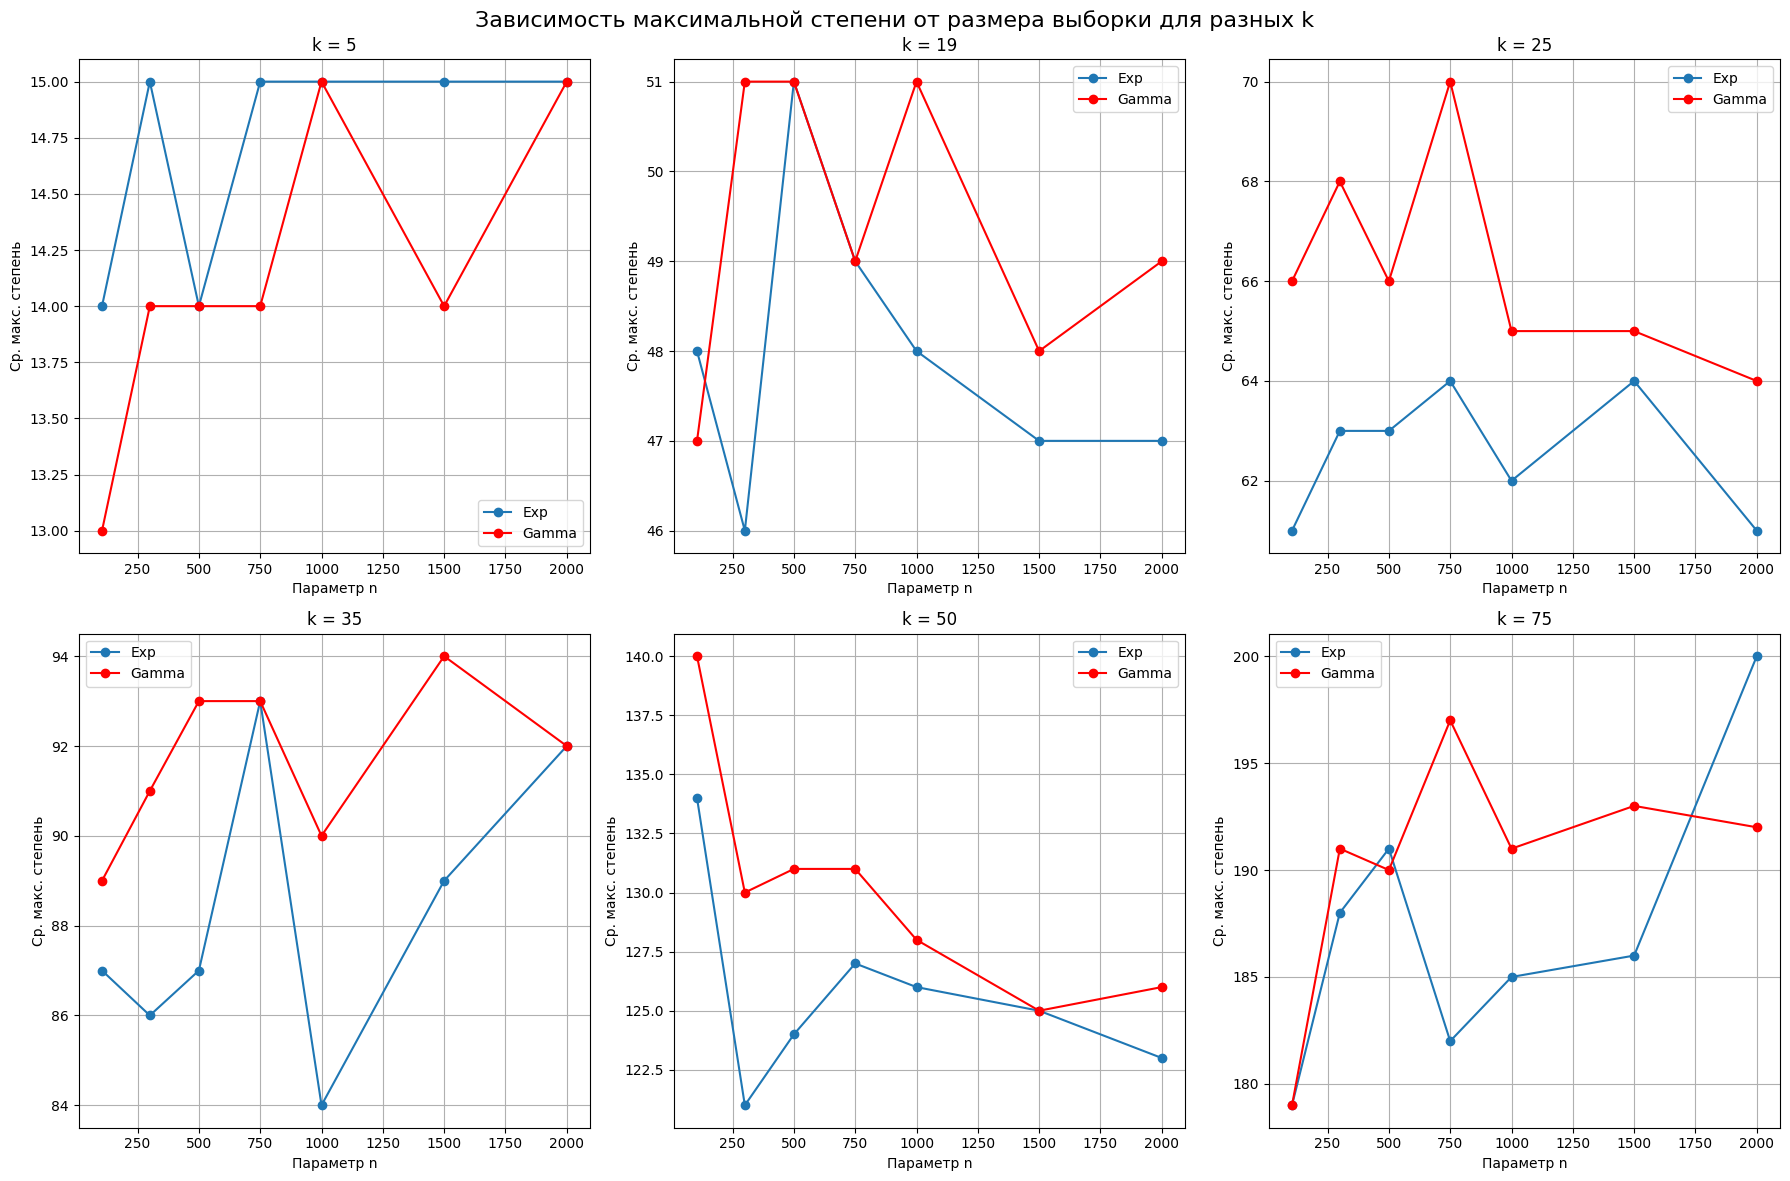

In [18]:
param_grid = {
    'k_neighbors': [5, 19, 25, 35, 50, 75],
    'n': [105, 300, 500, 750, 1000, 1500, 2000]
}
n_trials = 1
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
fig.suptitle('Зависимость максимальной степени от размера выборки для разных k', fontsize=16)
for i, k in enumerate(tqdm(param_grid['k_neighbors'], desc='Processing k_neighbors')):
    max_degrees_means = []
    for n in param_grid['n']:
        max_degrees = []
        for _ in range(n_trials):
            samples = generate_exponential_samples(n, 1)
            G = generate_knn_digraph(samples, k)
            max_degree = max_node_degree(G)
            max_degrees.append(max_degree)
        max_degrees_means.append(np.mean(max_degrees))
    ax = axes[i//3, i%3]
    ax.plot(param_grid['n'], max_degrees_means, marker='o', label='Exp')
    max_degrees_means = []
    for n in param_grid['n']:
        max_degrees = []
        for _ in range(n_trials):
            samples = generate_gamma_samples(n, 1/np.sqrt(2))
            G = generate_knn_digraph(samples, k)
            max_degree = max_node_degree(G)
            max_degrees.append(max_degree)
        max_degrees_means.append(np.mean(max_degrees))
    ax.plot(param_grid['n'], max_degrees_means, marker='o', color='red', label='Gamma')
    ax.set_title(f'k = {k}')
    ax.set_xlabel('Параметр n')
    ax.set_ylabel('Ср. макс. степень')
    ax.legend()
    ax.grid(True)
plt.tight_layout()
plt.show()

При больших k график Гамма-распределения находится выше экспоненциального распределения.

Эксперементы с графом dist.

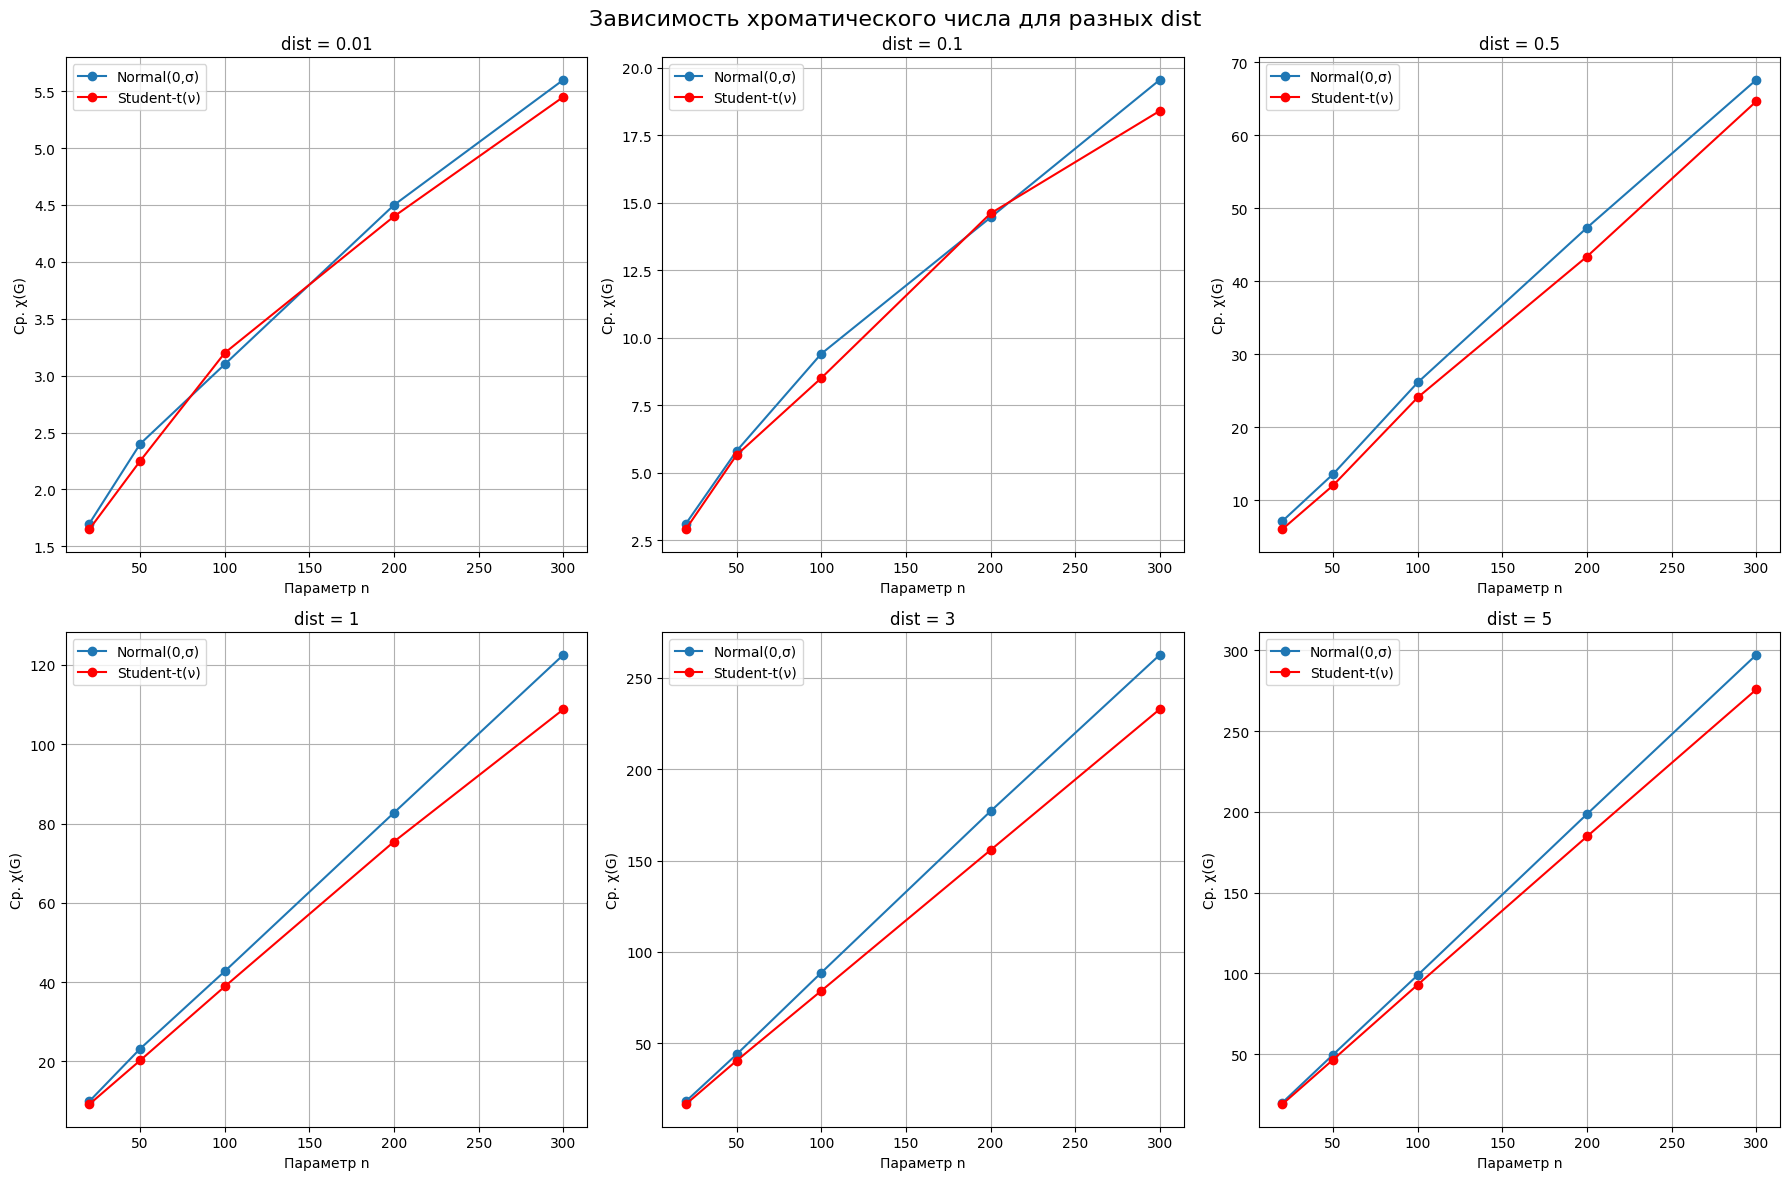

In [19]:
param_grid = {
    'dist': [0.01, 0.1, 0.5, 1, 3, 5],
    'n': [20, 50, 100, 200, 300]
}
n_trials = 20
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
fig.suptitle('Зависимость хроматического числа для разных dist', fontsize=16)
for i, d in enumerate(param_grid['dist']):
    chromatic_means = []
    for n in param_grid['n']:
        chromatics = []
        for _ in range(n_trials):
            samples = generate_normal_samles(n)
            G = generate_distance_graph(samples, d = d)
            chromatic = chromatic_number(G)
            chromatics.append(chromatic)
        chromatic_means.append(np.mean(chromatics))
    ax = axes[i//3, i%3]
    ax.plot(param_grid['n'], chromatic_means, marker='o', label='Normal(0,σ)')
    chromatic_means = []
    for n in param_grid['n']:
        chromatics = []
        for _ in range(n_trials):
            samples = generate_standard_t_samles(n)
            G = generate_distance_graph(samples, d = d)
            chromatic = chromatic_number(G)
            chromatics.append(chromatic)
        chromatic_means.append(np.mean(chromatics))
    ax.plot(param_grid['n'], chromatic_means, marker='o', color='red', label='Student-t(ν)')
    ax.set_title(f'dist = {d}')
    ax.set_xlabel('Параметр n')
    ax.set_ylabel('Ср. χ(G)')
    ax.legend()
    ax.grid(True)
plt.tight_layout()
plt.show()


К сожалению данные графики не сильно отличаются, в среднем график для Student-t(ν) ниже чем график для нормального распределения.

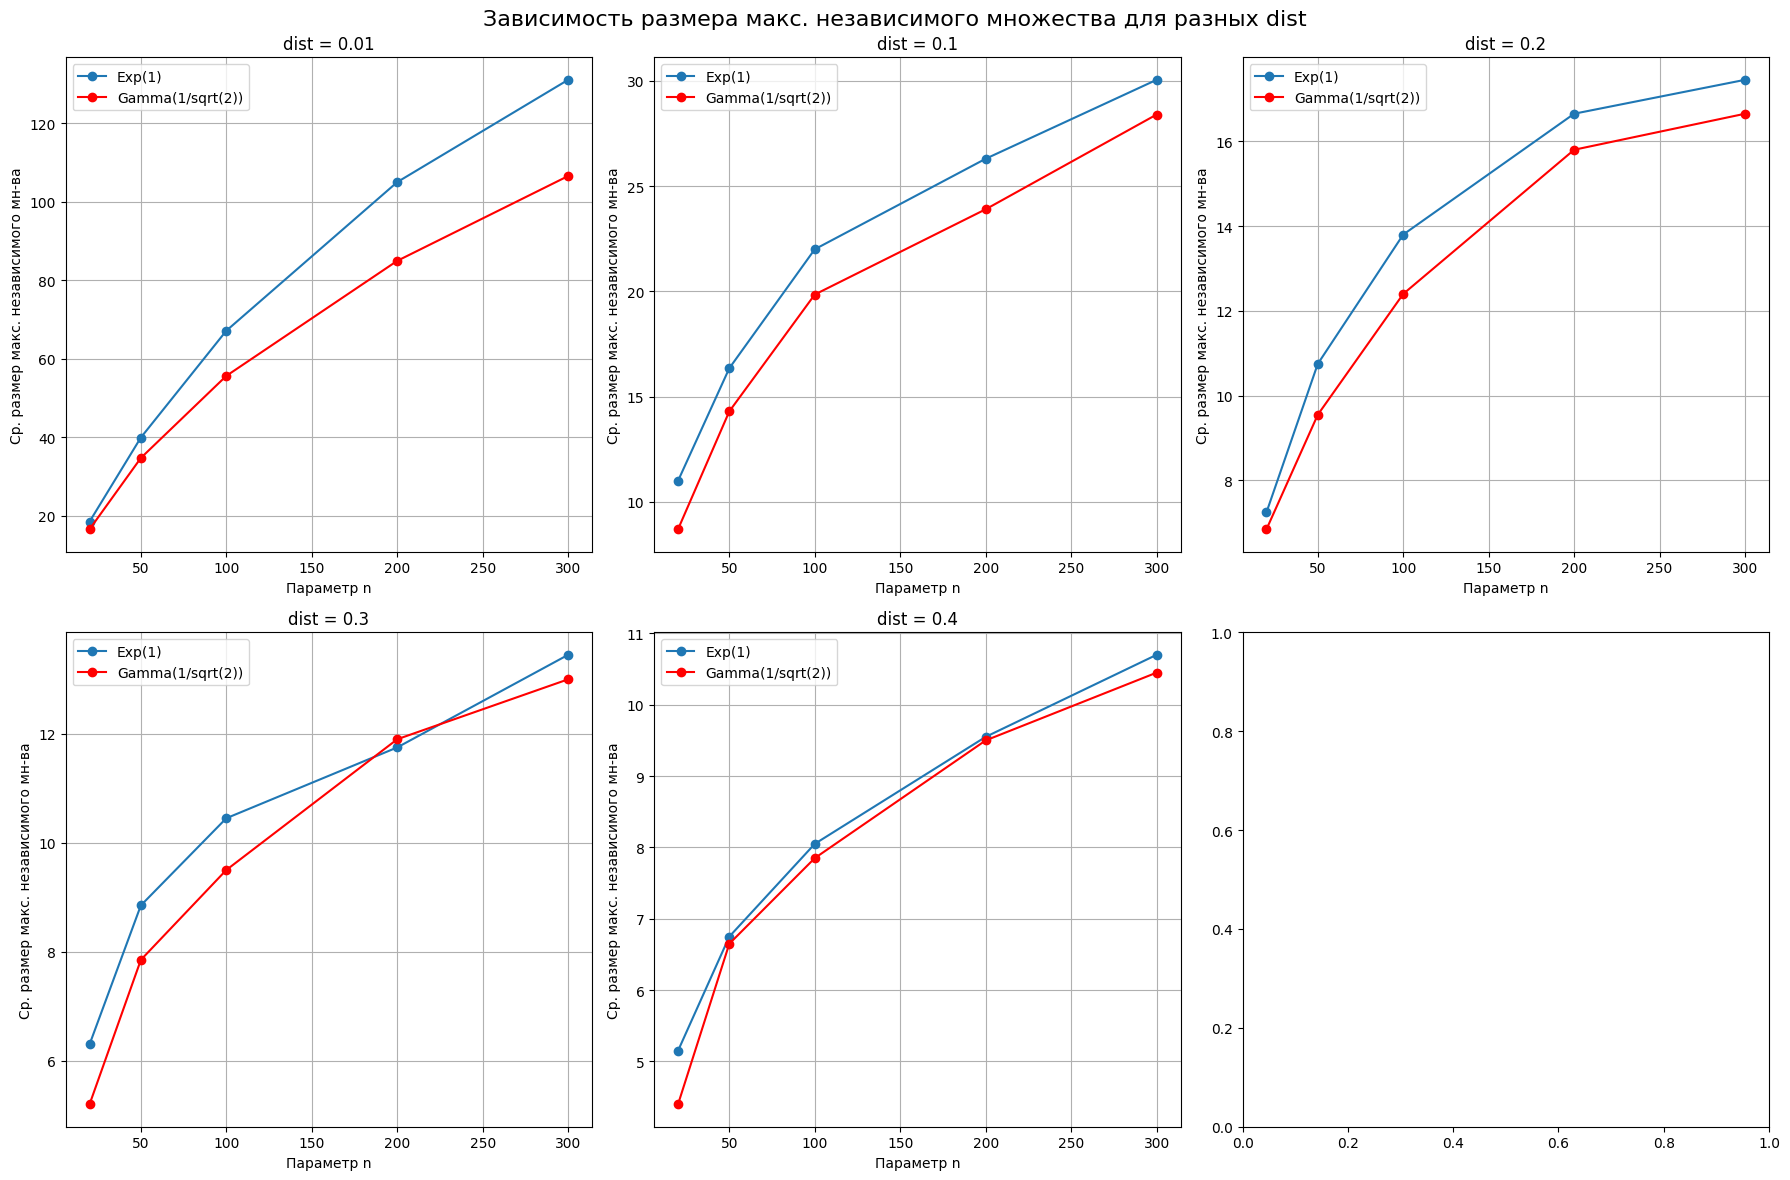

In [20]:
param_grid = {
    'dist': [0.01, 0.1, 0.2, 0.3, 0.4],
    'n': [20, 50, 100, 200, 300]
}
n_trials = 20
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
fig.suptitle('Зависимость размера макс. независимого множества для разных dist', fontsize=16)
for i, d in enumerate(param_grid['dist']):
    indep_means = []
    for n in param_grid['n']:
        indeps = []
        for _ in range(n_trials):
            samples = generate_exponential_samples(n, 1)
            G = generate_distance_graph(samples, d = d)
            indep = max_independent_set_size(G)
            indeps.append(indep)
        indep_means.append(np.mean(indeps))
    ax = axes[i//3, i%3]
    ax.plot(param_grid['n'], indep_means, marker='o', label='Exp(1)')
    indep_means = []
    for n in param_grid['n']:
        indeps = []
        for _ in range(n_trials):
            samples = generate_gamma_samples(n, 1/np.sqrt(2))
            G = generate_distance_graph(samples, d = d)
            indep = max_independent_set_size(G)
            indeps.append(indep)
        indep_means.append(np.mean(indeps))
    ax.plot(param_grid['n'], indep_means, marker='o', color='red', label='Gamma(1/sqrt(2))')
    ax.set_title(f'dist = {d}')
    ax.set_xlabel('Параметр n')
    ax.set_ylabel('Ср. размер макс. независимого мн-ва')
    ax.legend()
    ax.grid(True)
plt.tight_layout()
plt.show()


Экспонента в среднем выше, чем гамма-распределение.

**Построить множество A в предположении $θ = θ_0$ и $υ = υ_0$ при максимальной допустимой вероятности ошибки первого рода α = 0.055.
Оценим мощность полученного критерия.**

Начнем с dist графом и характеристикой χ(G).

Воспользуемся свойством: в любом дистанционном графе χ(G) = ω(G) почти наверное.
И будем считать кликовое число для нашей выборки. Превратим каждое число выборки в отрезок: $\xi-> [\xi-d/2, \xi+d/2]$, после этого найдем точку, в которой пересекается наибольшее число отрезков. Это и будет кликовое(хроматическое) число графа.
Для этого отсортируем отрезки по левой границе и за линейное время пройдемся по всем отрезкам.

In [21]:
def fast_chromatic_number(samples, d):
  events=[]
  for xi in samples:
    events.append((xi-d/2, 'start'))
    events.append((xi+d/2, 'end'))
    events.sort(key=lambda x: (x[0], x[1] == 'start'))
  max_count = 0
  active_segments = 0

  for x, typ in events:
      if typ == 'start':
          active_segments += 1
          if active_segments > max_count:
              max_count = active_segments
      else:
          active_segments -= 1

  return max_count

In [22]:
def generate_values(n=500, n_trials=1000, d=1):
  T_H0=[]
  T_H1=[]
  for _ in tqdm(range(n_trials), desc="Испытаний"):
    samples_1 = generate_normal_samles(n)
    samples_2 = generate_standard_t_samles(n)
    chromatic_1 = fast_chromatic_number(samples_1, d)
    chromatic_2 = fast_chromatic_number(samples_2, d)
    T_H0.append(chromatic_1)
    T_H1.append(chromatic_2)
  return T_H0, T_H1

In [23]:
from tqdm import tqdm
np.random.seed(42)
n_trials = 1000 # Количество испытаний.
alpha = 0.055 # Максимальная допустимая ошибка первого рода.
n = 500 # Размер выборки, для которой мы хотим определять ккакому распределению она относится.
T_H0=[]# Значения нашей характеристики для нормального распределения
T_H1=[]# Значения нашей характеристики для Student-t(ν)
T_H0, T_H1 = generate_values(n, n_trials)

Испытаний: 100%|██████████| 1000/1000 [01:31<00:00, 10.93it/s]


In [24]:
def frequencies(T_H0, T_H1):
  P=[]
  for value in list(set(T_H0) | set(T_H1)):
    P.append([value, T_H0.count(value)/len(T_H0), T_H1.count(value)/len(T_H1)])
  return P

def sort_key(triple):
    _, b, c = triple
    if b == 0:
        return (float('-inf'),)
    return (-(c / b),)

def greedy(T_H0, T_H1, alpha=0.055):
  P = frequencies(T_H0, T_H1) #Массив частот значений(условно вероятностей)
  P.sort(key=sort_key)# Сортируем элементы по убыванию P(H_1)/P(H_0).
  #Теперь построим множество А. Но для удобства будем строить его дополнение.
  A=[]
  current_error = 0
  power = 0
  for value, p0, p1 in P:
    if current_error + p0< alpha:
      current_error+=p0
      power+=p1
      A.append(value)
    else:
      break
  A= (set(T_H0) | set(T_H1)).difference(set(A))
  return A, current_error, power

In [25]:
A, current_error, power = greedy(T_H0, T_H1, 0.055)
print(f'Множество A: {A}')
print(f'Ошибка первого рода: {current_error:.3f}')
print(f'Мощность: {power:.3f}')

Множество A: {183, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 229, 231, 234, 237, 238}
Ошибка первого рода: 0.045
Мощность: 0.594


Мы получили следующий результат: мощность полученного китерия 0.594, хороший ли это результат мне сложно сказать.

Теперь попробуем использовать KNN граф и характеристику δ(G).

In [26]:
n_trials = 1000 # Количество испытаний.
alpha = 0.055 # Максимальная допустимая ошибка первого рода.
n = 500 # Размер выборки, для которой мы хотим определять ккакому распределению она относится.
T_H0=[]# Значения нашей характеристики для нормального распределения
T_H1=[]# Значения нашей характеристики для Student-t(ν)
np.random.seed(42)
for _ in tqdm(range(n_trials), desc="Испытаний"):
  samples_1 = generate_normal_samles(n)
  G = generate_knn_digraph(samples_1, 100)
  delta_1 = min_node_degree(G)
  T_H0.append(delta_1)
  samples_2 = generate_standard_t_samles(n)
  G = generate_knn_digraph(samples_2, 100)
  delta_2 = min_node_degree(G)
  T_H1.append(delta_2)


Испытаний: 100%|██████████| 1000/1000 [03:24<00:00,  4.88it/s]


In [27]:
A, current_error, power = greedy(T_H0, T_H1, 0.055)
print(f'Множество A: {A}')
print(f'Ошибка первого рода: {current_error:.3f}')
print(f'Мощность: {power:.3f}')

Множество A: {3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24}
Ошибка первого рода: 0.035
Мощность: 0.717


Характеристика $in\delta(G)$ на графе KNN показывает лучшее результаты. При ошибке первого рода 0.035 мощность полученного критеия равна 0.717.

Работа с knn графом и макс. степенью вершины.

In [40]:
n_trials = 1000
alpha = 0.055
n = 500
T_H0=[]
T_H1=[]
np.random.seed(42)
for _ in tqdm(range(n_trials), desc="Испытаний"):
  samples_1 = generate_exponential_samples(n, 1)
  G = generate_knn_digraph(samples_1, 100)
  delta_1 = max_node_degree(G)
  T_H0.append(delta_1)
  samples_2 = generate_gamma_samples(n, 1/np.sqrt(2))
  G = generate_knn_digraph(samples_2, 100)
  delta_2 = max_node_degree(G)
  T_H1.append(delta_2)

Испытаний: 100%|██████████| 1000/1000 [03:43<00:00,  4.48it/s]


In [30]:
A, current_error, power = greedy(T_H0, T_H1, alpha)
print(f'Множество A: {A}')
print(f'Ошибка первого рода: {current_error:.3f}')
print(f'Мощность: {power:.3f}')

Множество A: {256, 257, 258, 259, 260, 261, 262, 235, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255}
Ошибка первого рода: 0.039
Мощность: 0.303


Работа с dist графом и размером макс. независимого мн-ва.

In [36]:
def fast_max_independent_set_size(graph):
    if not graph:
        return 0
    independent_set = set()
    nodes = set(graph.nodes())
    while nodes:
        node = nodes.pop()
        independent_set.add(node)
        neighbors = set(graph.neighbors(node))
        nodes.difference_update(neighbors)
    return len(independent_set)

In [37]:
n_trials = 1000
alpha = 0.055
n = 500
T_H0=[]
T_H1=[]
np.random.seed(42)
for _ in tqdm(range(n_trials), desc="Испытаний"):
  samples_1 = generate_exponential_samples(n, 1)
  G = generate_distance_graph(samples_1, 100)
  delta_1 = fast_max_independent_set_size(G)
  T_H0.append(delta_1)
  samples_2 = generate_gamma_samples(n, 1/np.sqrt(2))
  G = generate_distance_graph(samples_2, 100)
  delta_2 = fast_max_independent_set_size(G)
  T_H1.append(delta_2)

Испытаний: 100%|██████████| 1000/1000 [07:33<00:00,  2.20it/s]


In [39]:
A, current_error, power = greedy(T_H0, T_H1, alpha)
print(f'Множество A: {A}')
print(f'Ошибка первого рода: {current_error:.3f}')
print(f'Мощность: {power:.3f}')

Множество A: {256, 257, 258, 259, 260, 261, 262, 263, 236, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255}
Ошибка первого рода: 0.053
Мощность: 0.314
